In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Setup

In [61]:
plt.rcParams["figure.figsize"] = (20,10)
plt.style.use('ggplot')
pd.options.display.float_format= "{:.2f}".format

In [62]:
df = pd.read_csv("Walmart.csv")
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.57,211.10,8.11
1,1,12-02-2010,1641957.44,1,38.51,2.55,211.24,8.11
2,1,19-02-2010,1611968.17,0,39.93,2.51,211.29,8.11
3,1,26-02-2010,1409727.59,0,46.63,2.56,211.32,8.11
4,1,05-03-2010,1554806.68,0,46.50,2.62,211.35,8.11
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,4.00,192.01,8.68
6431,45,05-10-2012,733455.07,0,64.89,3.98,192.17,8.67
6432,45,12-10-2012,734464.36,0,54.47,4.00,192.33,8.67
6433,45,19-10-2012,718125.53,0,56.47,3.97,192.33,8.67


# Preprocess
* Based on a list of holiday, create a new column called ```Holiday_Event``` to map the the date of the holiday with the ```Date``` column of the data
* Convert ```Date``` column's data type from string to datetime
* Add ```Year``` and ```Month``` columns
* Sort the instances by date ascendingly
* Convert temperature's unit from Fahrenheit to Celsius

In [63]:
holiday_events = {
    'SuperBowl':['12-02-2010','11-02-2011','10-02-2012','08-02-2013'],
    'LabourDay':['10-09-2010','09-09-2011','07-09-2012','06-09-2013'],
    'Thanksgiving':['26-11-2010','25-11-2011','23-11-2012','29-11-2013'],
    'Christmas':['31-12-2010','30-12-2011','28-12-2012','27-12-2013']
    }

flatten_events = {val:key for key,lst in holiday_events.items() for val in lst}

df['Holiday_Event'] = df['Date'].map(flatten_events)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Temperature'] = (df['Temperature'] - 32 ) * (5/9)
df = df.sort_values(by='Date')
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Questions

## Q1. What should Walmart do to increase total sales in the next year for the top 3 least contributed stores?

### Get total sales of each store

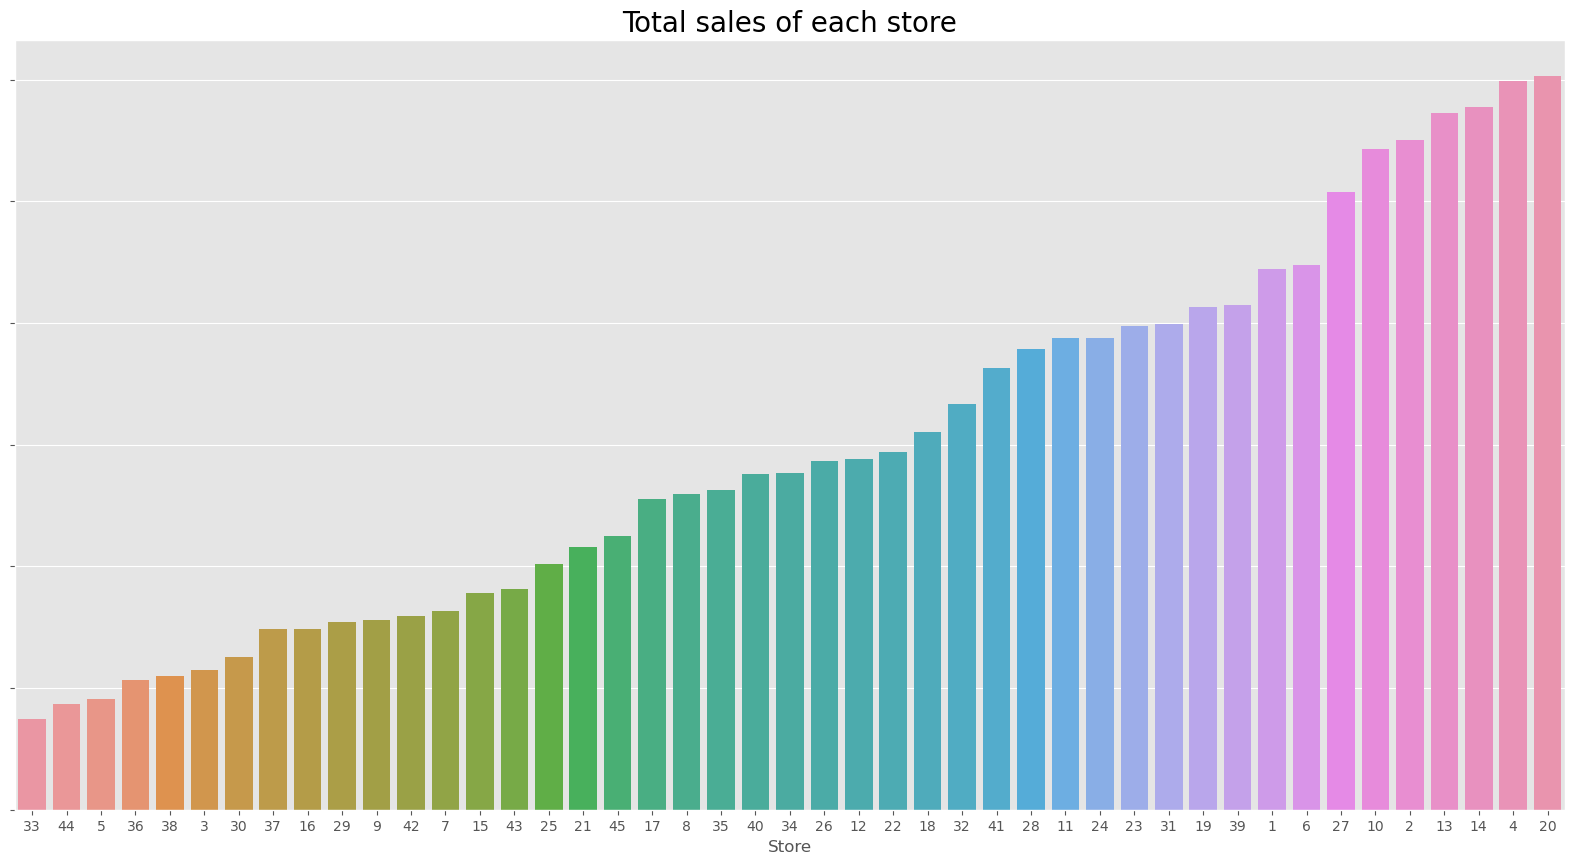

In [66]:
sales_by_store = df[['Store','Weekly_Sales']].groupby('Store').agg('sum').reset_index()
fig = sns.barplot(
    data=sales_by_store,x='Store',y='Weekly_Sales',
    order=sales_by_store.sort_values(by='Weekly_Sales')['Store']);

fig.set_title('Total sales of each store',fontsize=20);
fig.set_ylabel('')
fig.set_yticklabels([]);

### Top 3 lowest sales stores

In [79]:
top3_lowest = sales_by_store.sort_values(by='Weekly_Sales').head(3)
top3_lowest

,Store,Weekly_Sales
32,33,37160221.96
43,44,43293087.84
4,5,45475688.90


# Cutting down the expense

### Fuel price trend in the latest year

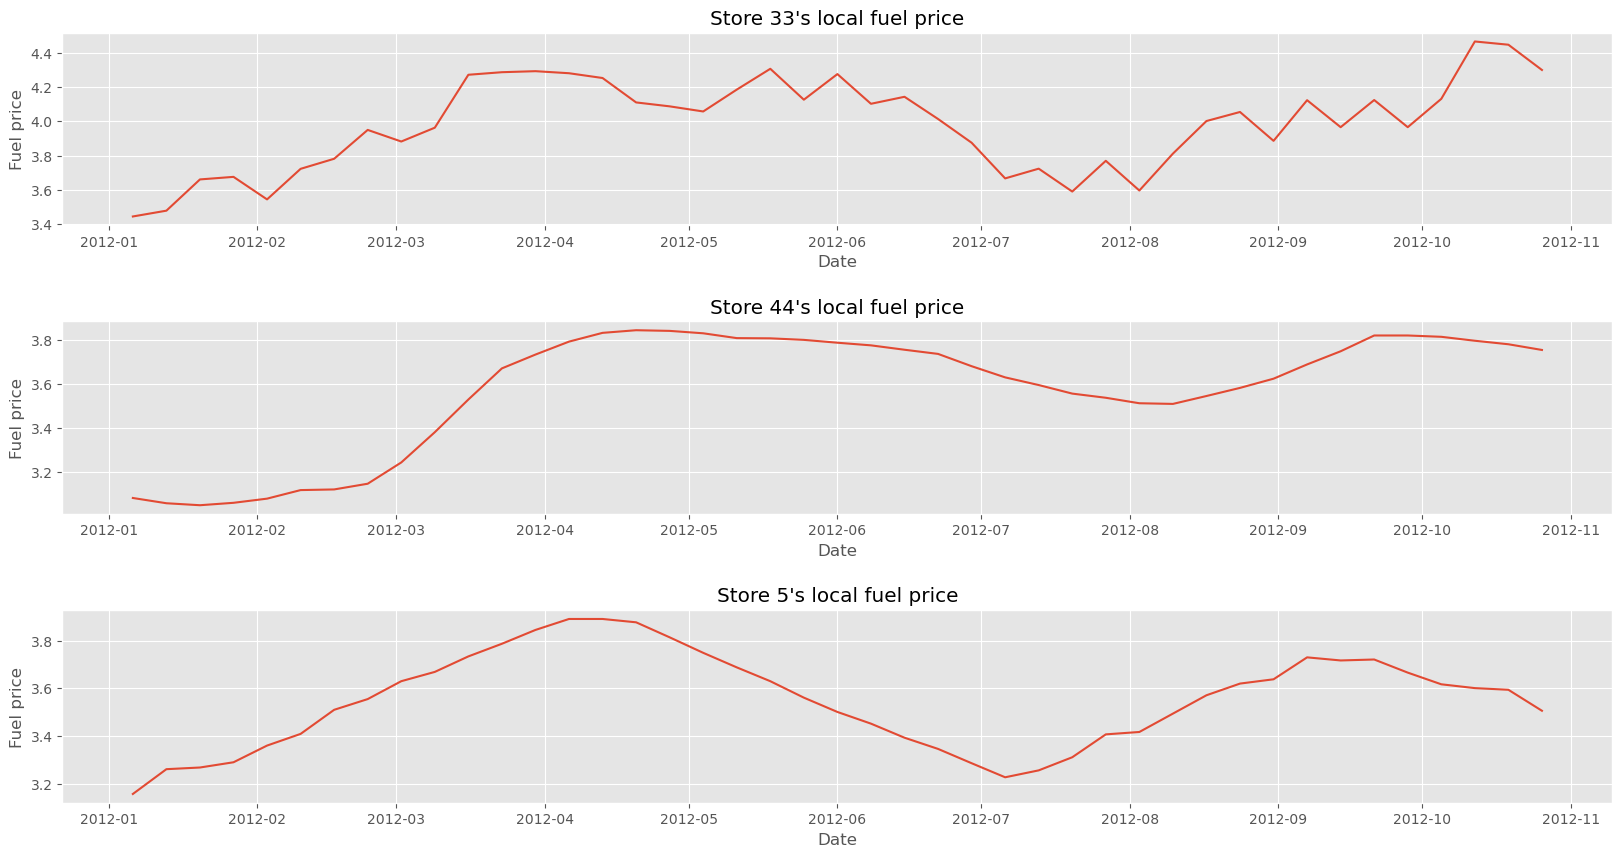

In [105]:
latest_year = df['Year'].max()

fig, axes = plt.subplots(3,1)

plt.subplots_adjust(hspace=0.5)
for i in range(top3_lowest['Store'].shape[0]):
    store_no = top3_lowest['Store'].iloc[i]
    data = df[(df['Store'] == store_no) & (df['Year'] == latest_year)]
    axes[i].plot(data['Date'],data['Fuel_Price'])
    axes[i].set_title(f"Store {store_no}'s local fuel price")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Fuel price')

### Comment


### Local temperature 

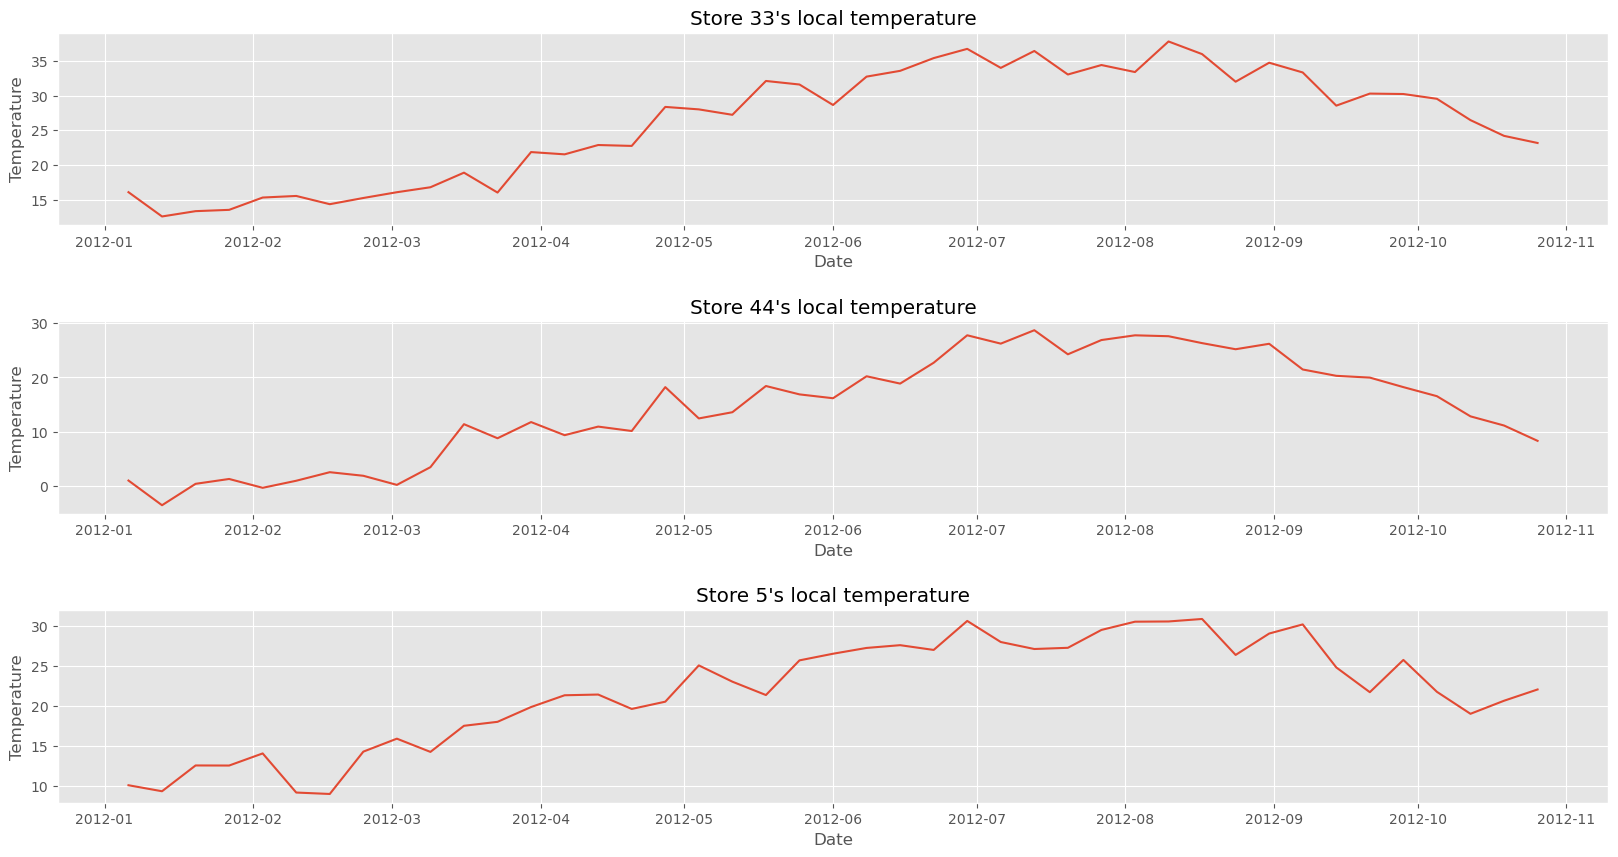

In [107]:
fig, axes = plt.subplots(3,1)

plt.subplots_adjust(hspace=0.5)
for i in range(top3_lowest['Store'].shape[0]):
    store_no = top3_lowest['Store'].iloc[i]
    data = df[(df['Store'] == store_no) & (df['Year'] == latest_year)]
    axes[i].plot(data['Date'],data['Temperature'])
    axes[i].set_title(f"Store {store_no}'s local temperature")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Temperature')